In [1]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
from IPython.display import display
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, shape

**churn_usersprofile**: Socio-demographic characterization and the residence area of the bus users. Information like the gender, age class, county of origin of bus users can be very useful for this challenge.  
**churn_od**: Demand for public transportation in each county of origin and its respective parish of destination.  

**Goals**: Create a framework that will allow to measure the increase and decrease the passengers of public transport towards cities that are more inclusive and sustainable.  
**Outcome**: Given the public transports users’ profile in two periods, the aggregated OD matrix, and any other external or derived data, this exercise should produce the following major outcomes: Identify churn profiles and drivers, propose measures to win back lost segments and their expected impact.

In [2]:
up = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_UsersProfile.txt',
                                 encoding = "ISO-8859-1",
                                sep='|')
od = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_OD.txt',
                                 encoding = "ISO-8859-1",
                                sep='|', dtype={'Dicofre_ParishCode_of_Public_Transportation': str})

In [87]:
up.sample(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Period,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day
142,R1 - AM Lisboa,Setúbal,Seixal,Sep-19 to Feb-20,Female,15-24,1659.214870
95,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,Sep-19 to Feb-20,Male,35-44,137.425488


In [4]:
od.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Dicofre_ParishCode_of_Public_Transportation,Demand_weight
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110608,0.307323
1,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110639,0.069997


In [5]:
print(up.shape, od.shape)

(544, 7) (2253, 8)


In [6]:
set(up.Period)

{'Sep-19 to Feb-20', 'Sep-20 to Jan-21'}

# Analyzing Users Profile

In [7]:
up.columns

Index(['Region_of_Origin', 'District_of_Origin', 'County_of_Origin', 'Period',
       'GenderDescription', 'AgeClassDescription', 'Average_BusUsers_per_Day'],
      dtype='object')

In [8]:
up.County_of_Origin.unique()

array(['Amadora', 'Cascais', 'Lisboa', 'Loures', 'Mafra', 'Odivelas',
       'Oeiras', 'Sintra', 'Vila Franca de Xira', 'Alcochete', 'Almada',
       'Barreiro', 'Moita', 'Montijo', 'Palmela', 'Seixal', 'Sesimbra',
       'Setúbal', 'Espinho', 'Oliveira de Azeméis',
       'Santa Maria da Feira', 'Gondomar', 'Maia', 'Matosinhos',
       'Paredes', 'Porto', 'Póvoa de Varzim', 'Santo Tirso', 'Trofa',
       'Valongo', 'Vila do Conde', 'Vila Nova de Gaia', 'Arouca',
       'São João da Madeira', 'Vale de Cambra'], dtype=object)

 - We have single values for each combination of Period, County, Gender and Age

# Change DF

In [89]:
change_df = pd.read_csv('variation.csv')

# Churn Userprofiles Table

In [67]:
churn_df = change_df[change_df.Change<0]

In [84]:
churn_df.head(10)

,Region_of_Origin,District_of_Origin,County_of_Origin,GenderDescription,AgeClassDescription,Change,Change_pct
86,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,Female,25-34,-2.505004,-0.043873
219,R2 - AM Porto,Porto,Trofa,Male,35-44,-2.618801,-0.125641
120,R1 - AM Lisboa,Setúbal,Moita,Male,55-64,-4.481175,-0.263158
225,R2 - AM Porto,Porto,Valongo,Male,45-54,-7.422021,-0.051826
122,R1 - AM Lisboa,Setúbal,Montijo,Female,45-54,-9.367287,-0.278861
146,R1 - AM Lisboa,Setúbal,Sesimbra,Male,25-34,-12.161867,-0.109695
164,R2 - AM Porto,Aveiro,Santa Maria da Feira,Female,45-54,-12.527012,-0.185370
92,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,Male,35-44,-12.933766,-0.094115
216,R2 - AM Porto,Porto,Santo Tirso,Female,35-44,-13.143120,-0.307346
137,R1 - AM Lisboa,Setúbal,Seixal,Female,55-64,-15.365188,-0.064906


In [82]:
for col in churn_df.columns:
    if churn_df[col].dtype == 'object':
        display(churn_df.value_counts(col).to_frame())

,0
Region_of_Origin,
R1 - AM Lisboa,124
R2 - AM Porto,67


,0
District_of_Origin,
Lisboa,79
Porto,56
Setúbal,45
Aveiro,11


,0
County_of_Origin,
Lisboa,11
Odivelas,10
Sintra,10
Cascais,10
Vila Franca de Xira,10
Porto,10
Gondomar,9
Oeiras,8
Seixal,8


,0
GenderDescription,
Female,98
Male,93


,0
AgeClassDescription,
35-44,45
45-54,43
25-34,37
55-64,30
15-24,20
65+,16


# Analyzing Demand Table

In [19]:
od.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Dicofre_ParishCode_of_Public_Transportation,Demand_weight
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110608,0.307323
1,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110639,0.069997


In [20]:
asa = fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")

In [21]:
freguesias = pd.read_excel('https://dados.gov.pt/pt/datasets/r/ec6ef805-c278-4b4d-ba9b-3116264f68b4', engine="openpyxl")[['dicofre', 'freguesia']]

In [22]:
od_freguesia = pd.merge(od, freguesias,
                    how='outer',left_on=['Dicofre_ParishCode_of_Public_Transportation'],
                    right_on=['dicofre']).dropna().drop(['dicofre', 'Dicofre_ParishCode_of_Public_Transportation'],1)

In [23]:
od_freguesia.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Demand_weight,freguesia
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,0.307323,Benfica
1,R1 - AM Lisboa,Lisboa,Cascais,R1 - AM Lisboa,LISBOA,LISBOA,0.068546,Benfica


In [64]:
all_counties = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_2.shp")])
origin_counties = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_2.shp")
    if pol['properties']['NAME_2'] in od_freguesia.County_of_Origin.unique()])
in_freguesias = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")
    if pol['properties']['NAME_3'] in od_freguesia.freguesia.unique()])
not_in_freguesias = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")
    if pol['properties']['NAME_3'] not in od_freguesia.freguesia.unique()])
all_freguesias = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")])

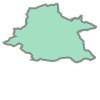

In [25]:
all_counties[0]

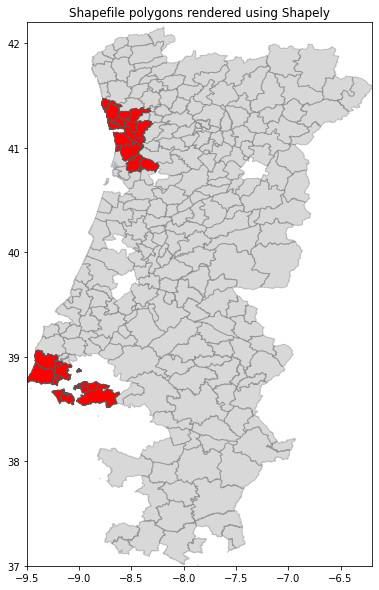

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#minx, miny, maxx, maxy = mp.bounds
#w, h = maxx - minx, maxy - miny
#ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
#ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)

# Whole Country
ax.set_xlim(-9.5, -6.2)
ax.set_ylim(37, 42.2)

# Lisbon Area
#ax.set_xlim(-9.5, -9)
#ax.set_ylim(38.5, 38.9)

ax.set_aspect(1)

patches = []
#for idx, p in enumerate(not_in_freguesias):
#    patches.append(PolygonPatch(p, fc='grey', ec='#555555', alpha=0.3, zorder=2))
#for idx, p in enumerate(in_freguesias):
#    patches.append(PolygonPatch(p, fc='red', ec='#555555', alpha=1., zorder=1))
for idx, p in enumerate(all_counties):
    patches.append(PolygonPatch(p, fc='grey', ec='#555555', alpha=0.3, zorder=2))
for idx, p in enumerate(origin_counties):
    patches.append(PolygonPatch(p, fc='red', ec='#555555', alpha=1., zorder=1))
ax.add_collection(PatchCollection(patches, match_original=True))
 


plt.title("Shapefile polygons rendered using Shapely")
plt.show()

In [30]:
# Demands sum to a value very close to 1 on the county level
od_freguesia.groupby(['County_of_Origin'])['Demand_weight'].sum().to_frame().sort_values('Demand_weight', ascending=False).sample(5)

,Demand_weight
County_of_Origin,
Alcochete,1.000004
Oliveira de Azeméis,1.000000
Seixal,1.000001
Gondomar,1.000001
Trofa,1.000001


# Joining Both Tables

We can now have estimated demands for each county to parish pair, for every demographic available. This way we can see which routrs are avings strong churn for different demographics

In [40]:
es_demands = pd.merge(od_freguesia, change_df,
                    on=['County_of_Origin']).drop(['Region_of_Origin_x', 'District_of_Origin_x'], 1)

In [41]:
es_demands['Demand_change'] = es_demands.Demand_weight * es_demands.Change

In [44]:
es_demands.sort_values('Demand_change', ascending = True).head(7)

,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Demand_weight,freguesia,Region_of_Origin_y,District_of_Origin_y,GenderDescription,AgeClassDescription,Change,Change_pct,Demand_change
13846,Maia,R2 - AM Porto,PORTO,PORTO,0.380782,"União das freguesias de Cedofeita, Santo Ildef...",R2 - AM Porto,Porto,Female,65+,-1665.556717,-1.171423,-634.214018
14851,Matosinhos,R2 - AM Porto,PORTO,MATOSINHOS,0.409841,"União das freguesias de Custóias, Leça do Bali...",R2 - AM Porto,Porto,Male,55-64,-1120.832499,-1.435300,-459.363112
5112,Oeiras,R1 - AM Lisboa,LISBOA,LISBOA,0.246656,Belém,R1 - AM Lisboa,Lisboa,Female,65+,-1827.413821,-0.806953,-450.742583
12258,Santa Maria da Feira,R2 - AM Porto,PORTO,PORTO,0.488625,União das freguesias de Lordelo do Ouro e Mass...,R2 - AM Porto,Aveiro,Male,15-24,-660.865266,-2.272823,-322.915291
10239,Seixal,R1 - AM Lisboa,LISBOA,LISBOA,0.197510,São Domingos de Benfica,R1 - AM Lisboa,Setúbal,Male,15-24,-1593.643038,-42.274250,-314.760436
14923,Matosinhos,R2 - AM Porto,PORTO,MATOSINHOS,0.272679,União das freguesias de São Mamede de Infesta ...,R2 - AM Porto,Porto,Male,55-64,-1120.832499,-1.435300,-305.627485
13956,Maia,R2 - AM Porto,PORTO,PORTO,0.159660,Paranhos,R2 - AM Porto,Porto,Female,65+,-1665.556717,-1.171423,-265.922785


In [34]:
es_demands.Demand_change.describe()

count    18267.000000
mean         9.048814
std        148.787913
min       -634.214018
25%          0.000000
50%          0.005665
75%          0.370493
max      11474.751085
Name: Demand_change, dtype: float64